In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(ptotallengths,gtotallengths,
                num_pconnections, num_gconnections, num_fpconnections, num_fgconnections):
    if num_fpconnections + num_fgconnections < 2:
        return "ucf"
    elif num_pconnections == 1 and num_gconnections ==0:# and num_mconnections==4: #gtotallengths>48
        return "p"
    elif num_pconnections == 0 and num_gconnections ==1:# and num_mconnections == 4:
        return "g"
    elif num_pconnections == 1 and num_gconnections ==1:# and num_mconnections ==3:
        return "b"
    else:
        return "ucf"
    
def connect(cv, radii, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    num_f_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_d = vector_dist(cv, cv2)
        total_separations += vector_d
        r1,r2 = radii
        if vector_d <= 2*r1 and vector_d > .2*r1: # blob centers closer than diameter of one blob
            num_connections += 1
        if vector_d <= 2*r2 and vector_d > .2*r1: # blob centers closer than diameter of one blob
            num_f_connections += 1
        else:
            pass
        if vector_d <= 4*r1: 
            normalized_dists.append(vector_d/(2*norm_radius))
    return ([num_connections, num_f_connections], normalized_dists, total_separations)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
connect_test = connect((0, 0),(2, 2), [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

([1, 1], [0.1, 0.1414213562373095, 0.0], 19.97056274847714) [5.0, 10.0] hello


In [4]:
grp1 = [1, [95, 67], 2]
grp2 = [2, [9.0], 13]
print(grp1+grp2)
print([grp1[i]+grp2[i] for i in range(len(grp1))])

[1, [95, 67], 2, 2, [9.0], 13]
[3, [95, 67, 9.0], 15]


In [5]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    p_bond = 15*1
    g_bond = 15*1
    fp_bond = 15*1.4
    fg_bond = 15*1.5
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        
        phighlight = morphology.binary_opening(thresh_img, disk(8))
        img = np.copy(frame)
        img[phighlight==0] = 0
        pblobs =skimage.feature.blob_doh(img, min_sigma =8, max_sigma = 17, threshold = 0.007, num_sigma= 15, overlap=0.5)
        
        ghighlight = gaussian(
        opening(
             (thresh_img^phighlight)
                           , disk(1)), sigma = 0.65)
        
        img = np.copy(frame)
        img[ghighlight==0] = 0
        gblobs =skimage.feature.blob_doh(img, min_sigma =9, max_sigma = 16, threshold = 0.005, num_sigma= 15, overlap=0.2)
    
        
        blobset.append([pblobs, gblobs])
        ngblobs = len(gblobs)
        npblobs = len(pblobs)         
        blobs = np.vstack((gblobs, pblobs  ))
        num_blobs = len(blobs)
        
        """plas_on_glas_dists =[connect((pblob[1], pblob[0]),m_bond, gblobs) for pblob in pblobs]
        plas_on_glas_dists = [sum([pog[0] for pog in plas_on_glas_dists]), 
                              list(chain(*[pog[1] for pog in plas_on_glas_dists])),
                             sum([pog[2] for pog in plas_on_glas_dists])]
        num_mconnections = plas_on_glas_dists[0]
        mdistances = plas_on_glas_dists[1]
        mtotallengths = plas_on_glas_dists[2]"""
        
        glas_on_glas_dists =[connect((gblobs[i][1], gblobs[i][0]),(g_bond, fg_bond), gblobs[i+1:]) for i in range(ngblobs-1)]
        glas_on_glas_dists = [[sum([gog[0][0] for gog in glas_on_glas_dists]), sum([gog[0][1] for gog in glas_on_glas_dists])], 
                              list(chain(*[gog[1] for gog in glas_on_glas_dists])),
                             sum([gog[2] for gog in glas_on_glas_dists])]
        num_gconnections,num_fgconnections  = glas_on_glas_dists[0]
        gdistances = glas_on_glas_dists[1]
        gtotallengths = glas_on_glas_dists[2]
        
        plas_on_plas_dists = [connect((pblobs[i][1], pblobs[i][0]),(p_bond, fp_bond), pblobs[i+1:]) for i in range(npblobs-1)]
        plas_on_plas_dists = [[sum([pop[0][0] for pop in plas_on_plas_dists]), sum([pop[0][1] for pop in plas_on_plas_dists])], 
                              list(chain(*[pop[1] for pop in plas_on_plas_dists])),
                             sum([pop[2] for pop in plas_on_plas_dists])]
        num_pconnections, num_fpconnections = plas_on_plas_dists[0]
        pdistances = plas_on_plas_dists[1]
        ptotallengths = plas_on_plas_dists[2]
        
        
        
        num_opconnections = sum([num_pconnections, num_gconnections])#,num_mconnections])
        distances = list(chain(pdistances, gdistances))       
        totallengths = sum([ptotallengths, gtotallengths])
        
        #----------------------filter------------------------- can use actual filter
        properties = {'num_blobs':num_blobs,
                      'num_pblobs':npblobs,
                      'num_gblobs':ngblobs,
                      'num_opconnections': num_opconnections,
                      'num_pconnections':num_pconnections, 
                      'num_gconnections':num_gconnections, 
                      'num_fpconnections':num_fpconnections,
                      'num_fgconnections':num_fgconnections,
                     'totallengths':totallengths, 
                      'ptotallengths':ptotallengths, 
                      'gtotallengths':gtotallengths, 
                     'distances':distances, 
                      'pdistances':pdistances, 
                      'gdistances':gdistances}
        #print(properties)
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = True#(num_connections >= expected_connections and num_blobs>=expected_blobs)
        if test: 
            #-----------------------------classify pt 1---------------------------------------
            clas = sideify(ptotallengths,gtotallengths,
                num_pconnections,num_gconnections, num_fpconnections, num_fgconnections)
            filtrate_prop.append(properties)
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






In [6]:
filenames = filename = glob("./tchakamau/De*both/*_[2,4].avi")+glob("./tchakamau/De*both/*_c.avi")#[1,3,4,5]glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 5
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
#needs reflled
phantom_frames = {"p" : list(range(1, 2400, 24)),
                  "g" :list(range(2843, 2915,1)),
                  "b" :list(range(14677, 14817, 1)),
                 "broken" :list(range(24708, 25042, 1) ),
                 "odd_s" :list() }

#---------------------------------------------------
phantom_frames_2 = {"p" : list(range(9960, 10260, 3)),
                  "g" :list(range(22750, 23050, 3)), 
                  "b" :list(range(1, 300, 3)),
                 "broken" :list(range(9327, 9536, 2)),
                 "odd_s" :list(range(23136, 23146, 1))}


phantom_frames_3 = {"p" : list(range(1, 300, 3)),
                  "g" :list(range(10340, 10390, 6)), 
                  "b" :list(range(9267, 9386, 1)),
                 "broken" :list(range(9848,9873, 1)) ,
                 "odd_s" :list(chain(range(8725,8732, 1), range(10401, 10439, 1)))}
#-----------------------------------
phantom_frames_4 = {"p" : list(range(975, 1126, 3)),
                  "g" :[], 
                  "b" :[],
                 "broken" :[],
                 "odd_s" :[]}

phantom_frame_sets = [phantom_frames,phantom_frames_2, phantom_frames_3]
trigger_frames = [1,1,1]


['./tchakamau\\Density_matchedboth\\45693_15Vpp_2.avi', './tchakamau\\Density_matchedboth\\45693_15Vpp_4.avi', './tchakamau\\Density_matchedboth\\45693_15Vpp_8_c.avi']


In [7]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["p", "g", "b", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if abs(tf-frameindex) in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], abs(tf-frameindex)))
           
        frameindex += 1
    
    
""" for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        
        frames = 
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])
"""

<generator object vreader at 0x0000020CC5674048>
<generator object vreader at 0x0000020CC5670C48>
<generator object vreader at 0x0000020CBFB1B7C8>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

In [8]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i])
    fil = len(x[0])
    pas = len(x[1])
    print(orig, fil, pas)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", pas*100/orig)
        p_rats.append(pas*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

302 302 288
p _vid
original_vid:  302
filtrate:  302
pass ratio:  95.36423841059603


181 181 147
g _vid
original_vid:  181
filtrate:  181
pass ratio:  81.21546961325967


360 360 300
b _vid
original_vid:  360
filtrate:  360
pass ratio:  83.33333333333333


55 55 14
odd_s _vid
original_vid:  55
filtrate:  55
pass ratio:  25.454545454545453


463 463 457
broken _vid
original_vid:  463
filtrate:  463
pass ratio:  98.70410367170626


5 5 5


In [9]:
names = {'num_blobs':[],
                      'num_pblobs':[],
                      'num_gblobs':[],
                      'num_opconnections': [],
                      'num_pconnections':[], 
                      'num_gconnections':[], 
                      'num_fpconnections':[], 
                      'num_fgconnections':[],
                     'totallengths':[], 
                      'ptotallengths':[], 
                      'gtotallengths':[], 
                     'distances':[], 
                      'pdistances':[], 
                      'gdistances':[]}
strings = names.keys()
distances = [string for string in strings if 'distances' in string]
simplenames = strings - distances
print(distances, simplenames)

['distances', 'pdistances', 'gdistances'] {'totallengths', 'num_opconnections', 'num_gconnections', 'num_fpconnections', 'num_fgconnections', 'num_pblobs', 'num_blobs', 'ptotallengths', 'num_pconnections', 'num_gblobs', 'gtotallengths'}


totallengths averages: 
p : 65 
g : 57 
b : 45 
odd_s : 66 
broken : 49 
totallengths variances: 
p : 60 
g : 90 
b : 157 
odd_s : 313 
broken : 1169 
num_opconnections averages: 
p : 1 
g : 1 
b : 2 
odd_s : 1 
broken : 1 
num_opconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_gconnections averages: 
p : 0 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_gconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fpconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 1 
broken : 1 
num_fpconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fgconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_fgconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_blobs averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
broken : 3 
num_blobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 

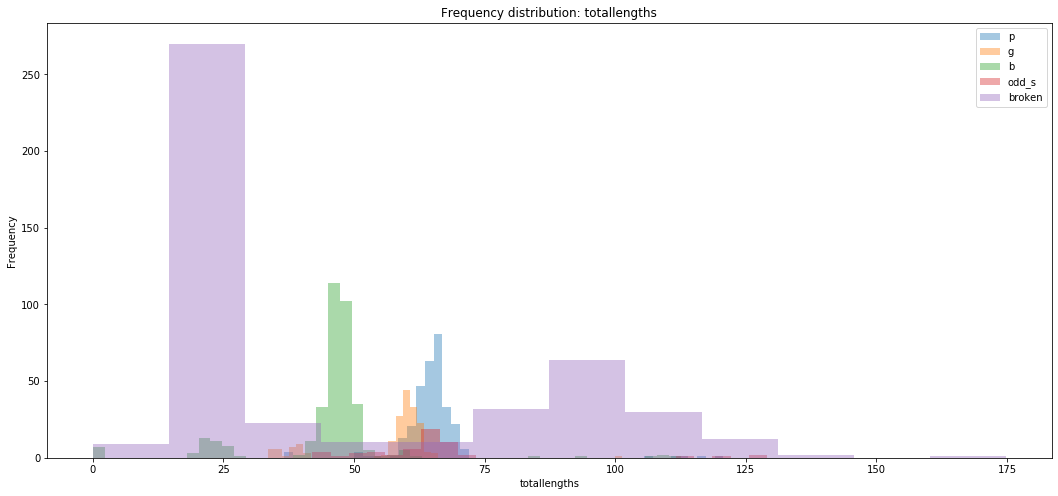

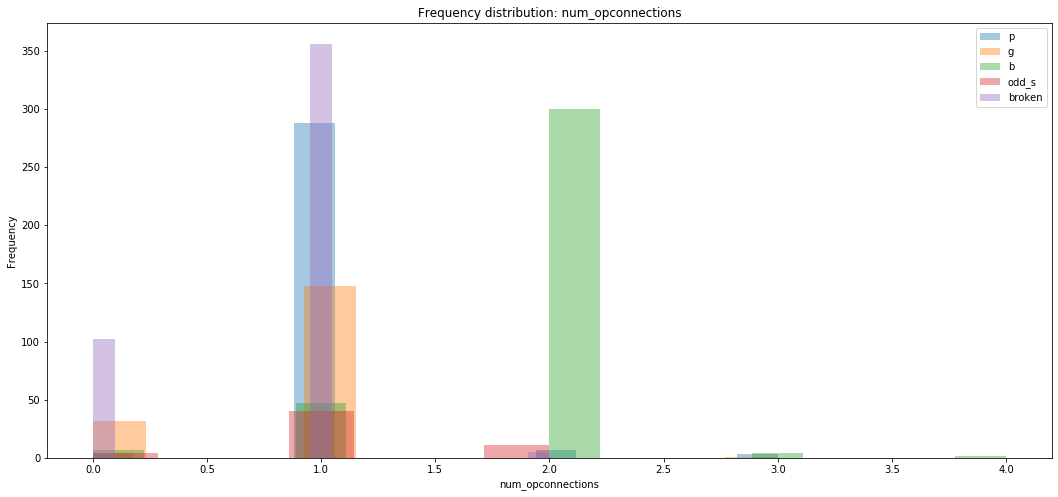

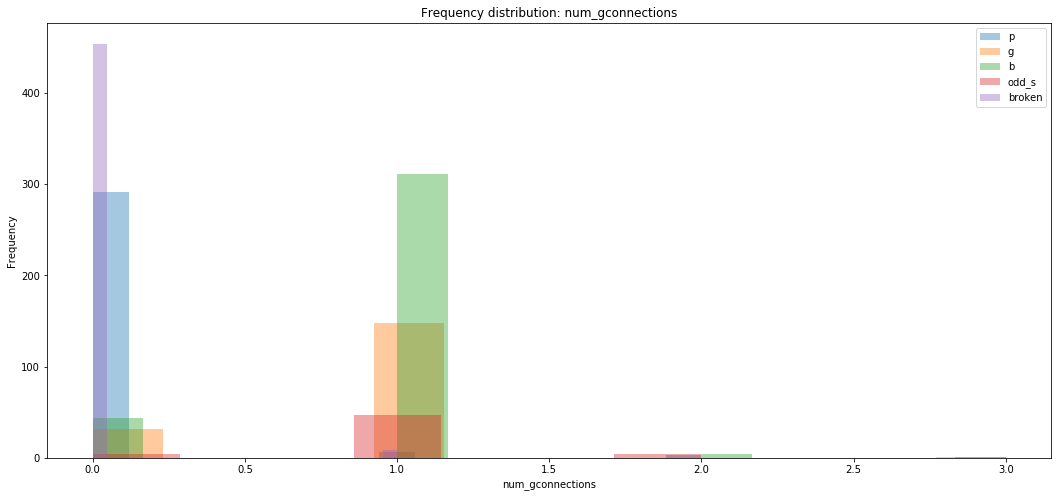

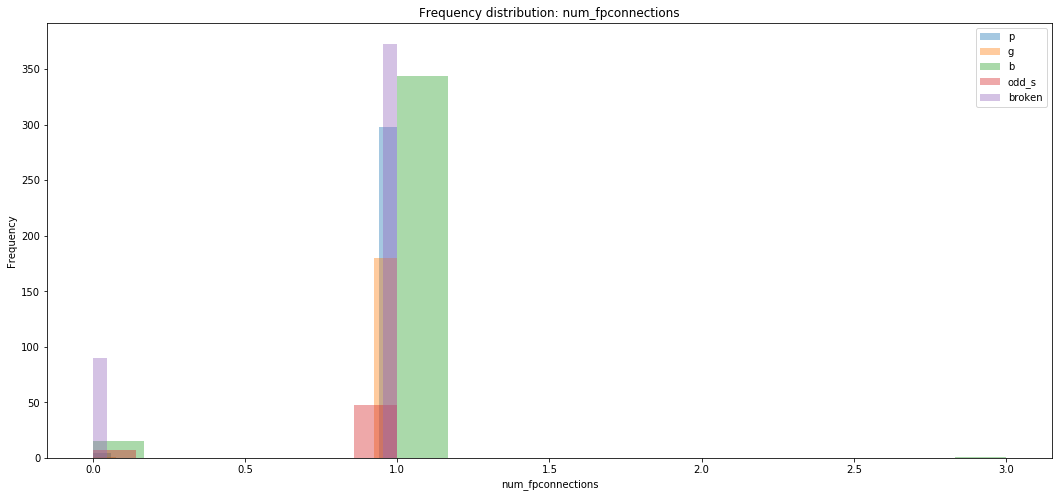

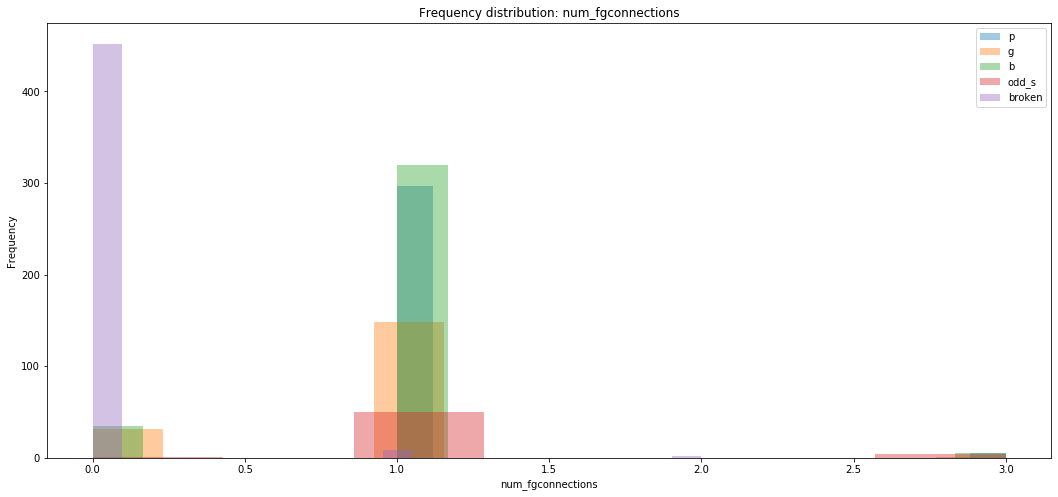

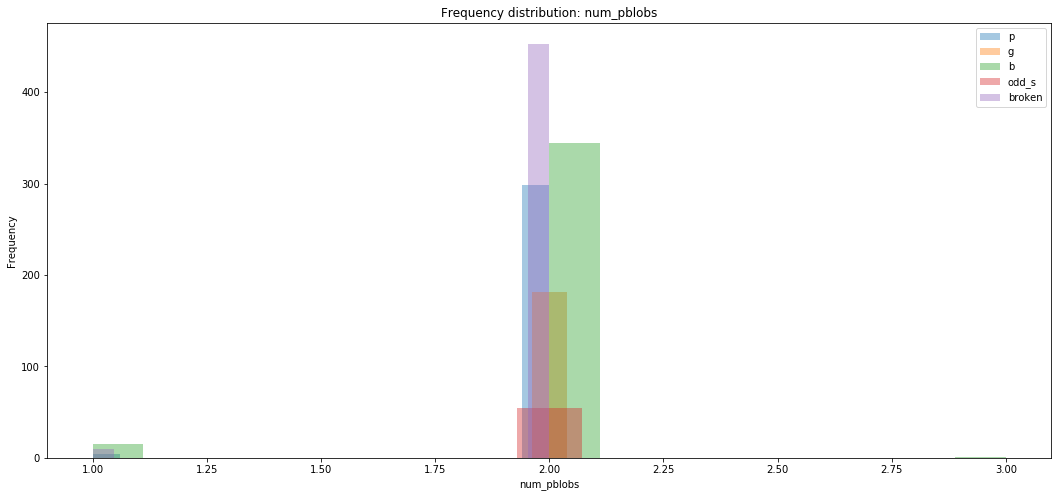

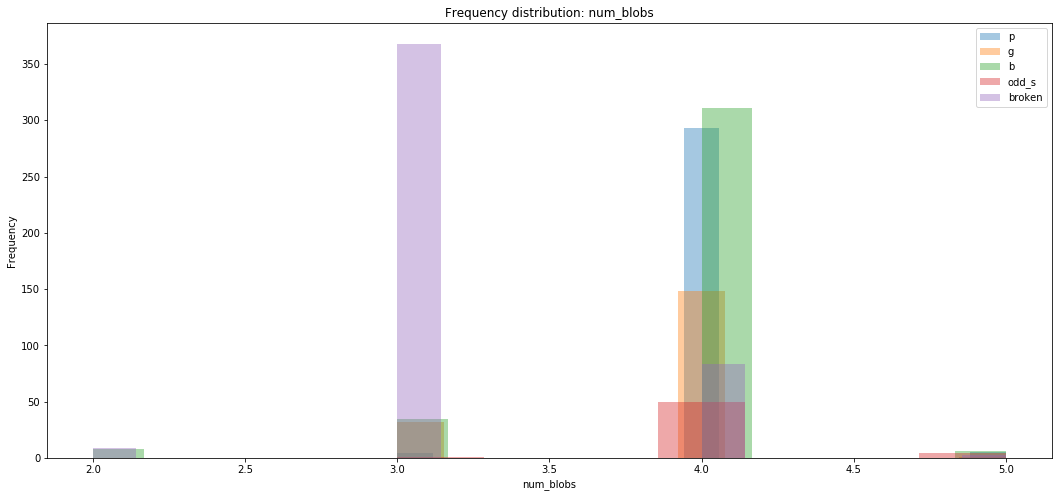

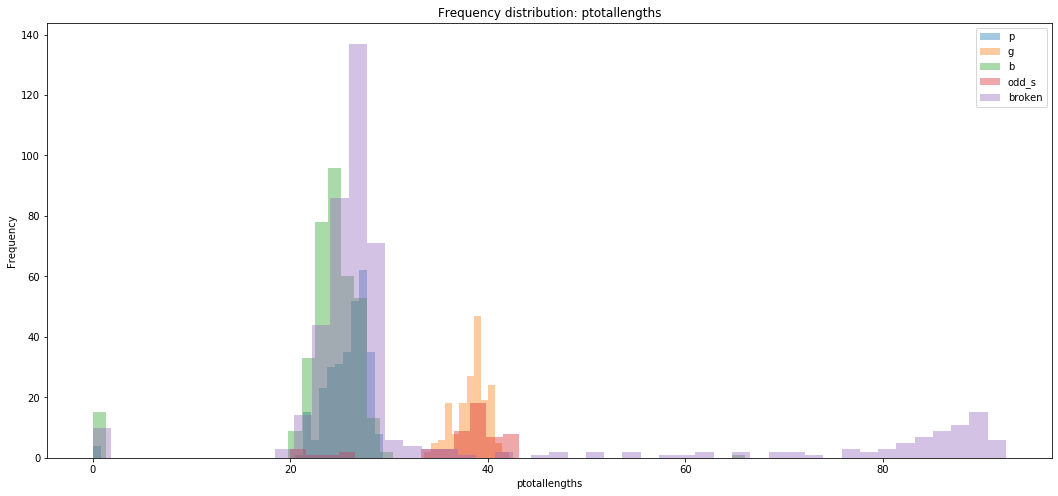

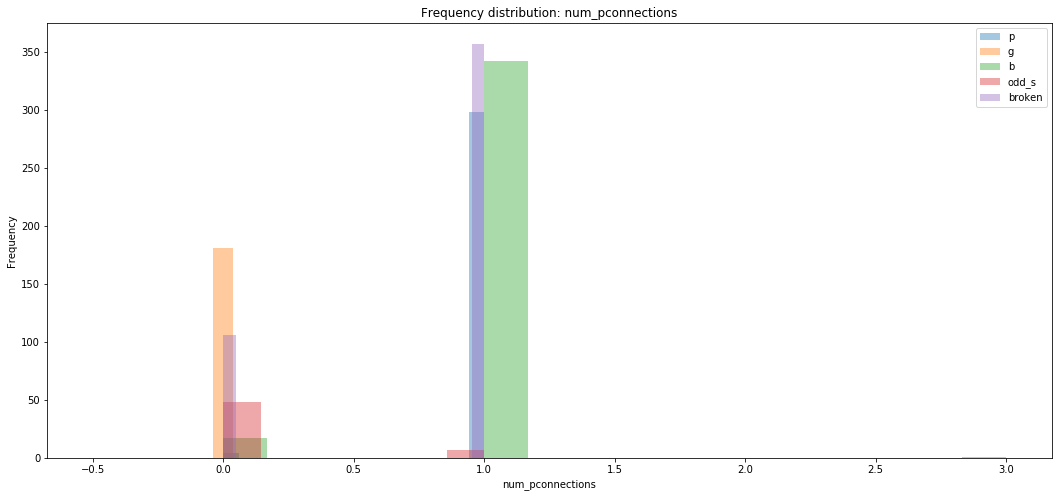

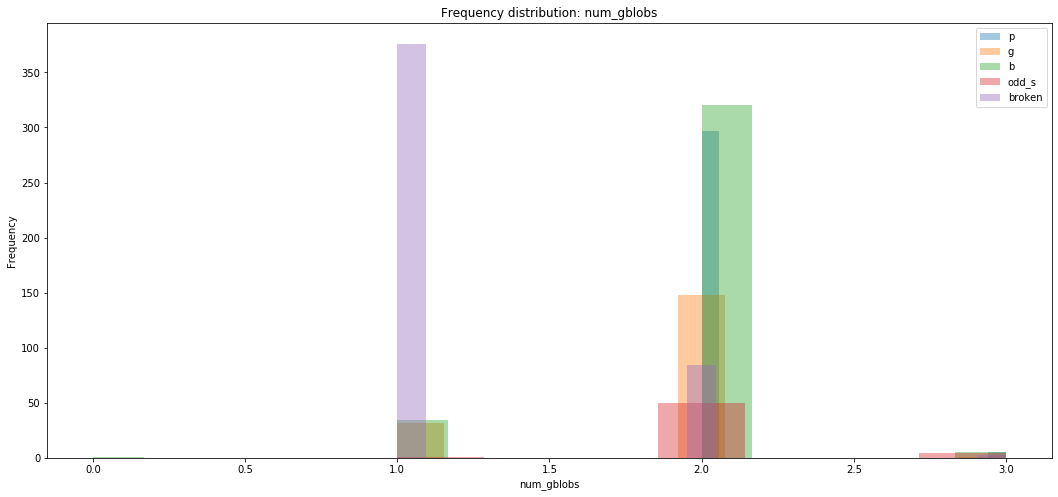

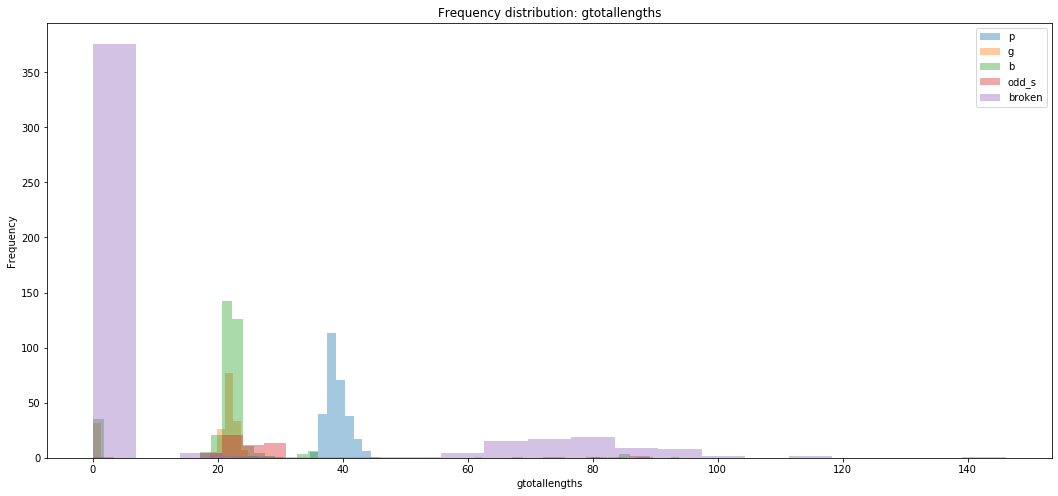

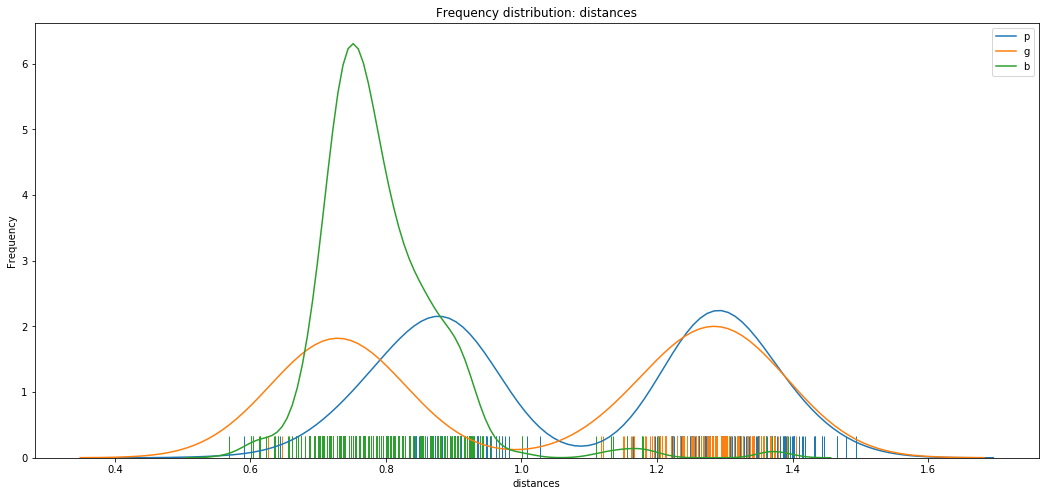

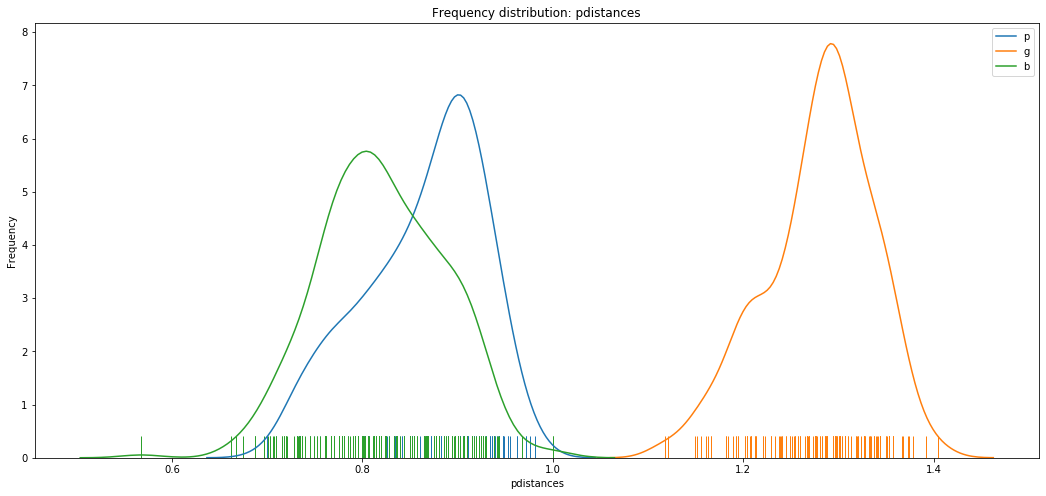

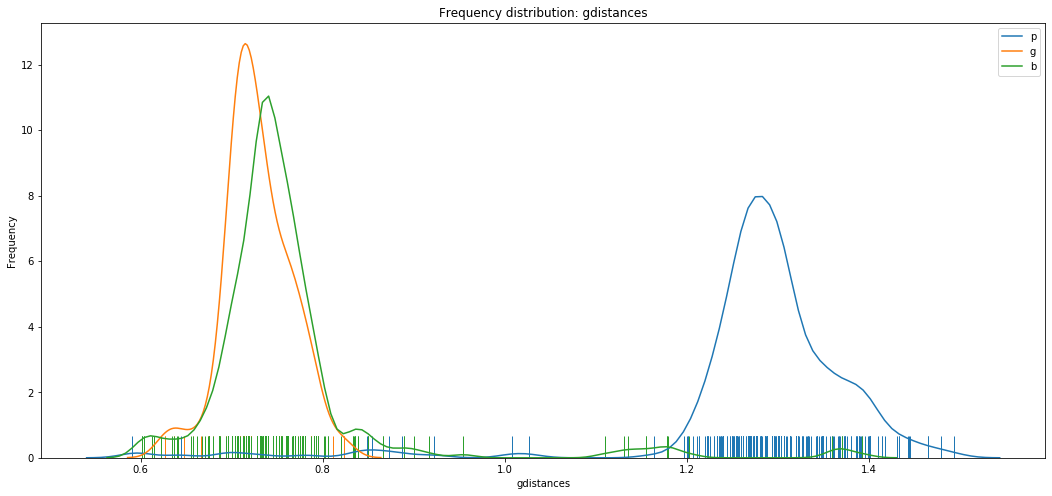

In [10]:
"""Everything"""

# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in a_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-2):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




totallengths averages: 
p : 65 
g : 57 
b : 45 
odd_s : 66 
broken : 49 
totallengths variances: 
p : 60 
g : 90 
b : 157 
odd_s : 313 
broken : 1169 
num_opconnections averages: 
p : 1 
g : 1 
b : 2 
odd_s : 1 
broken : 1 
num_opconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_gconnections averages: 
p : 0 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_gconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fpconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 1 
broken : 1 
num_fpconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fgconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_fgconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_blobs averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
broken : 3 
num_blobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 

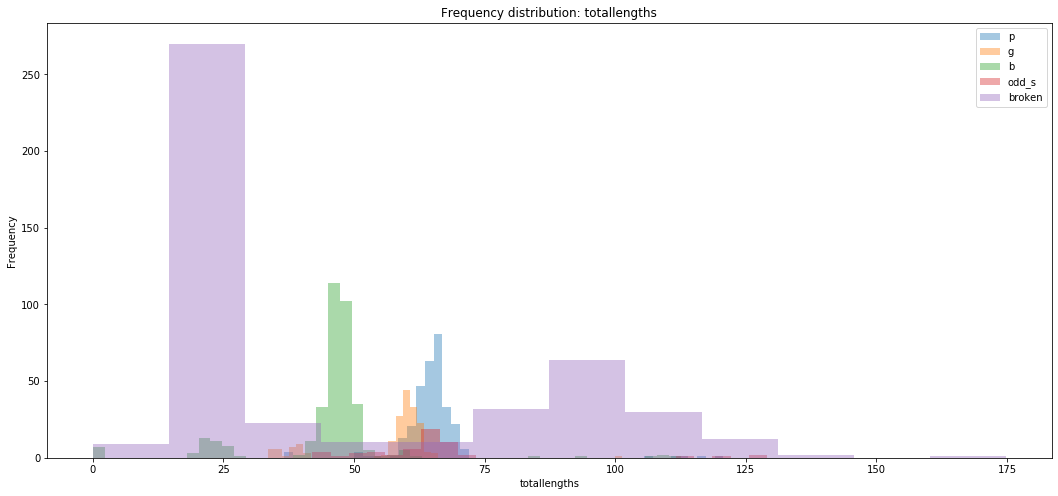

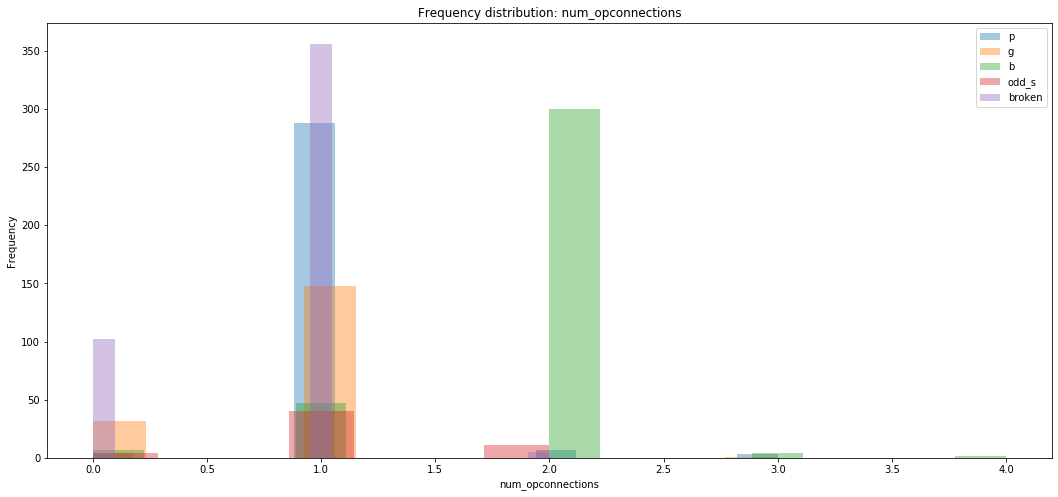

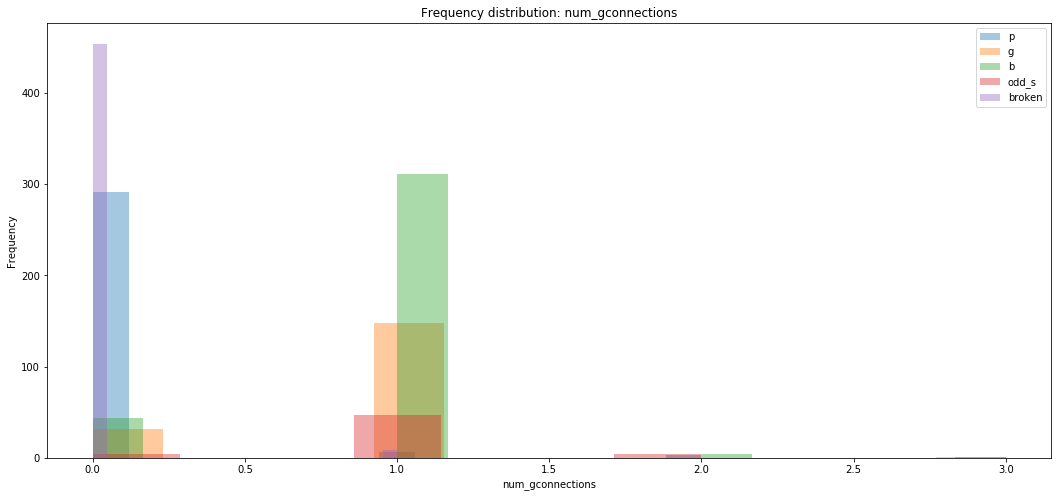

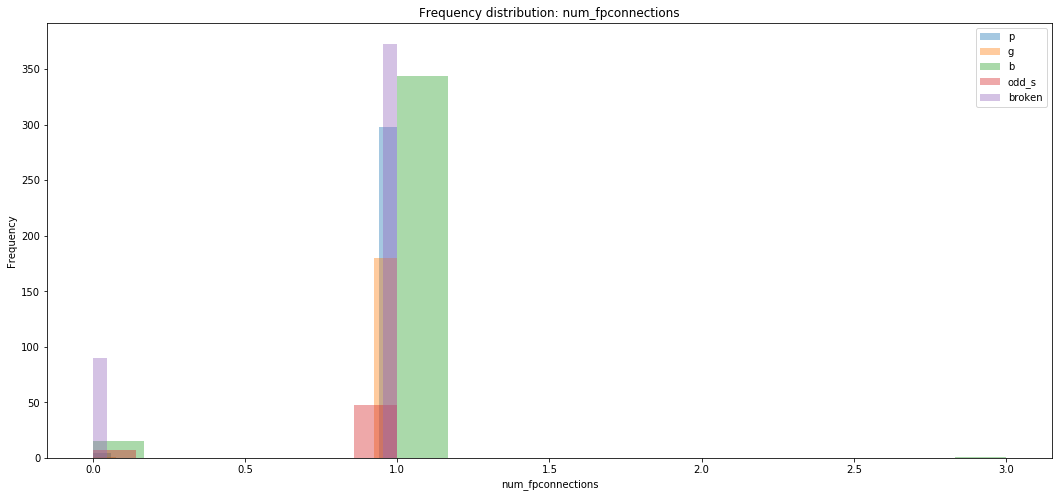

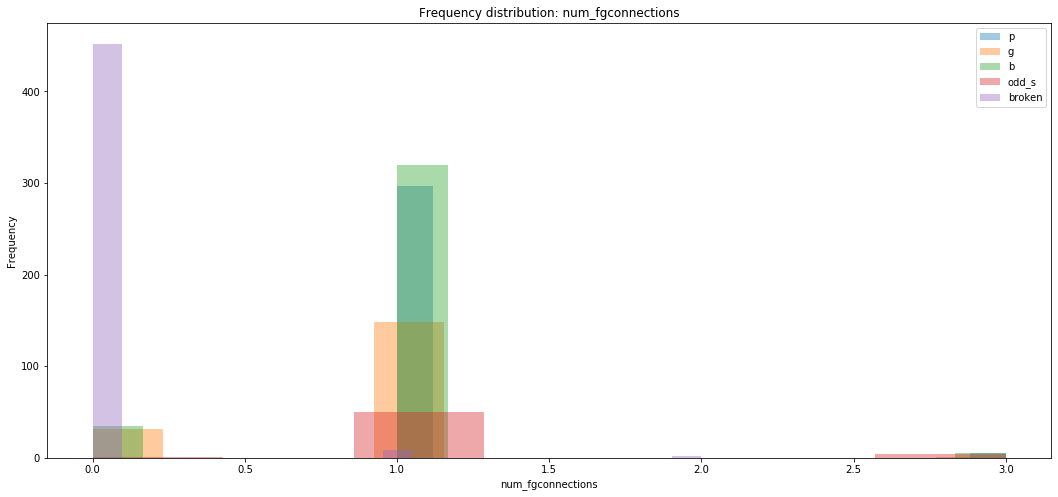

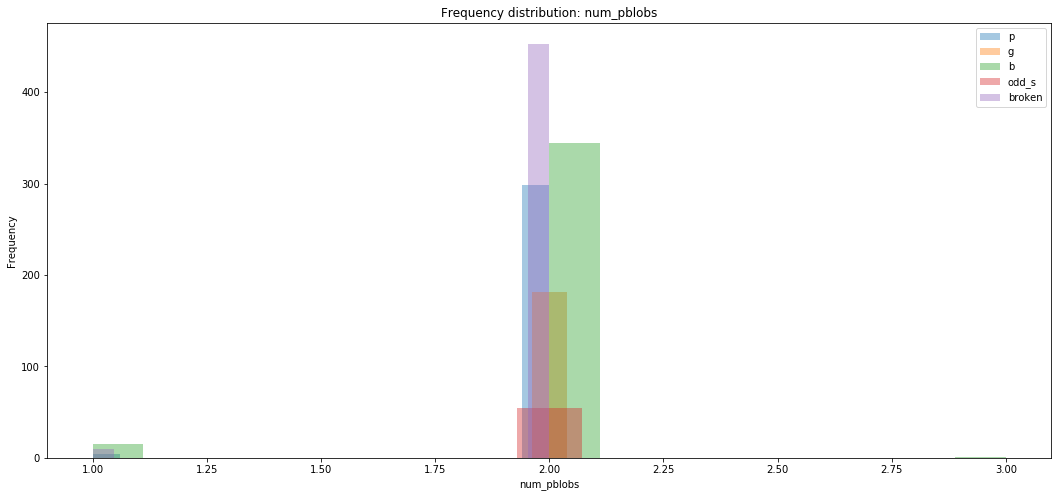

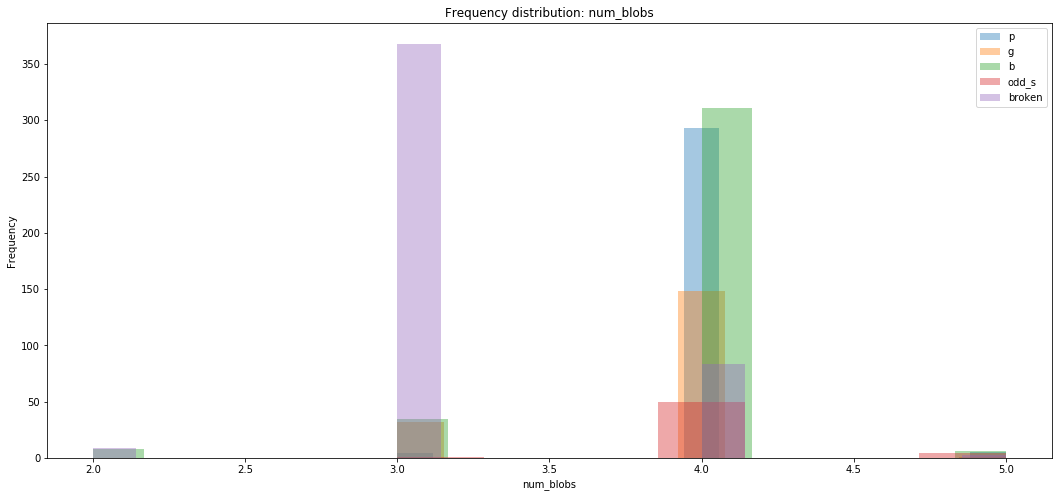

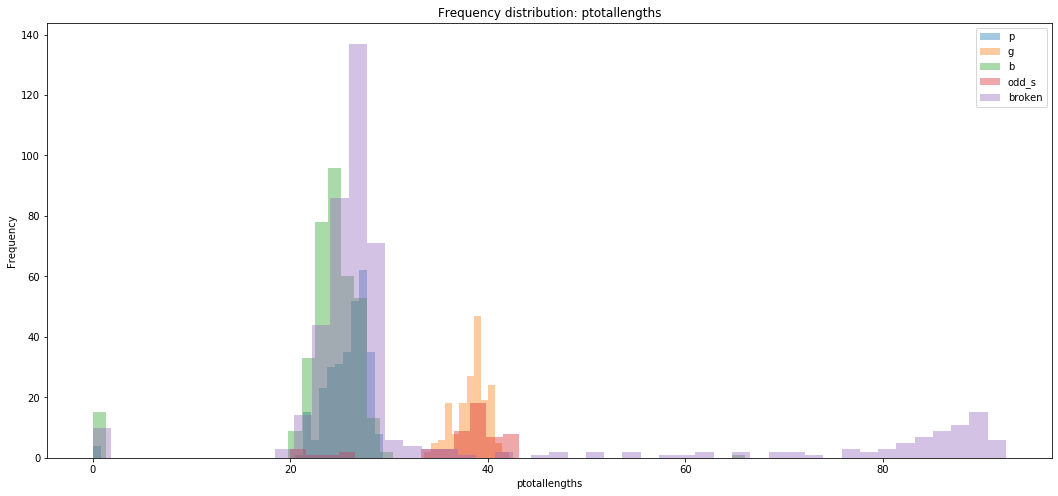

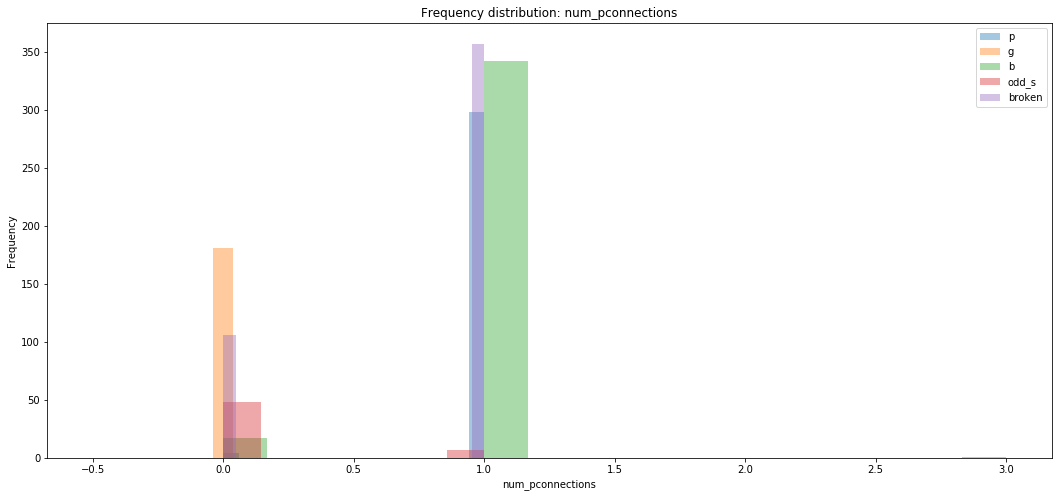

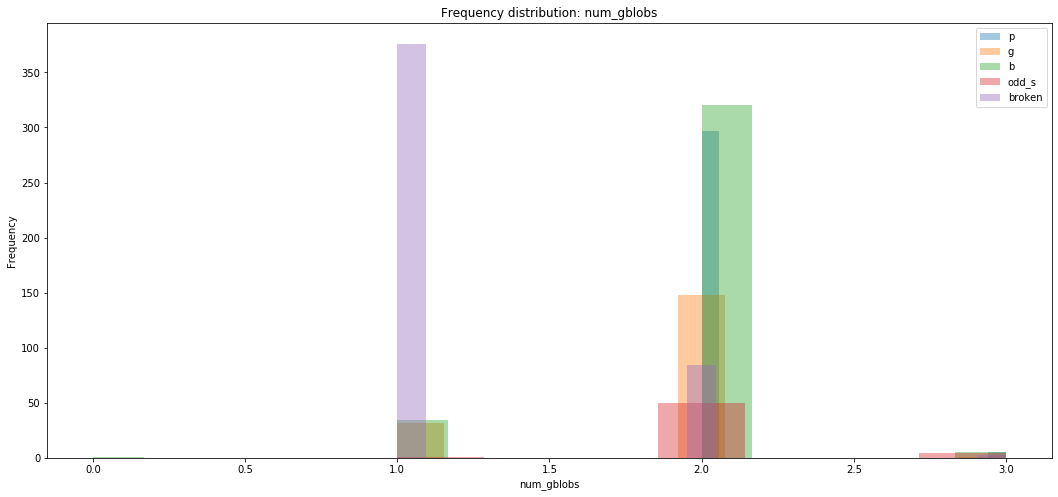

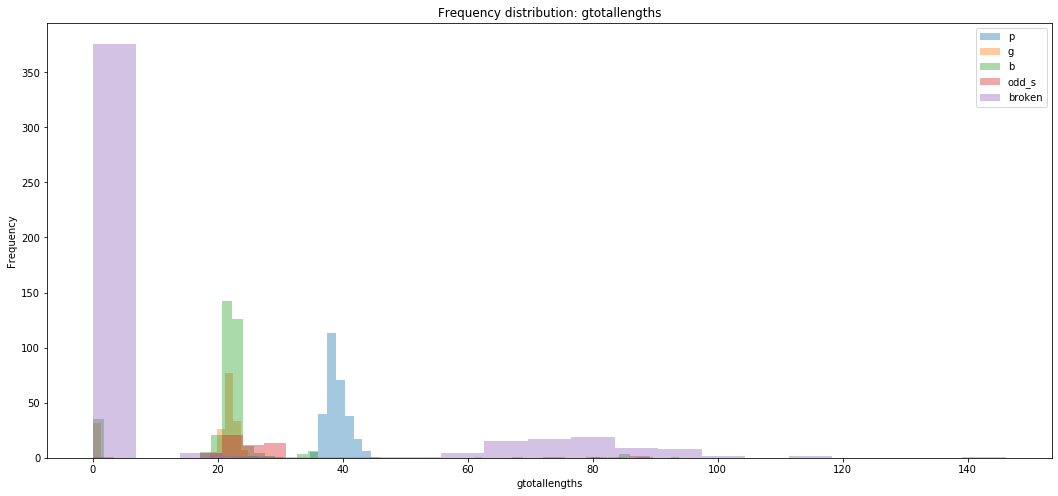

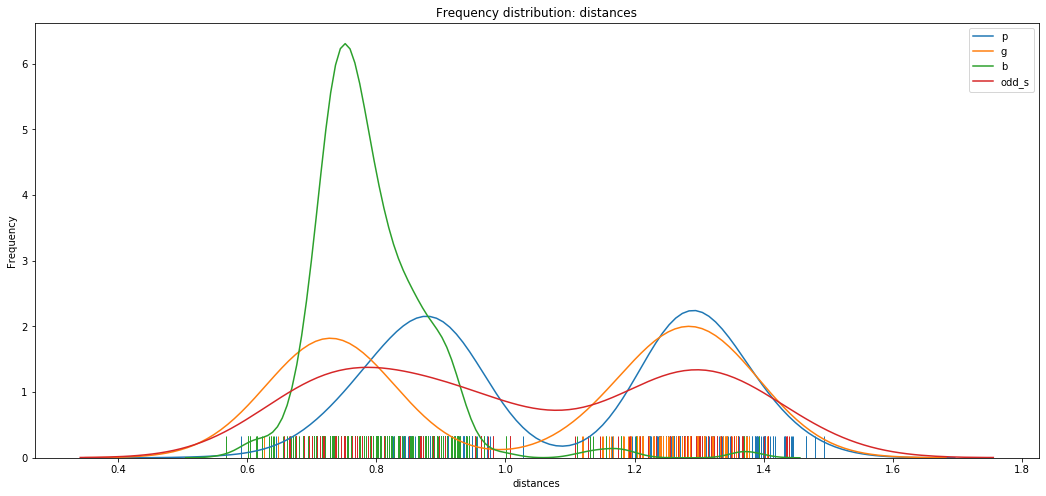

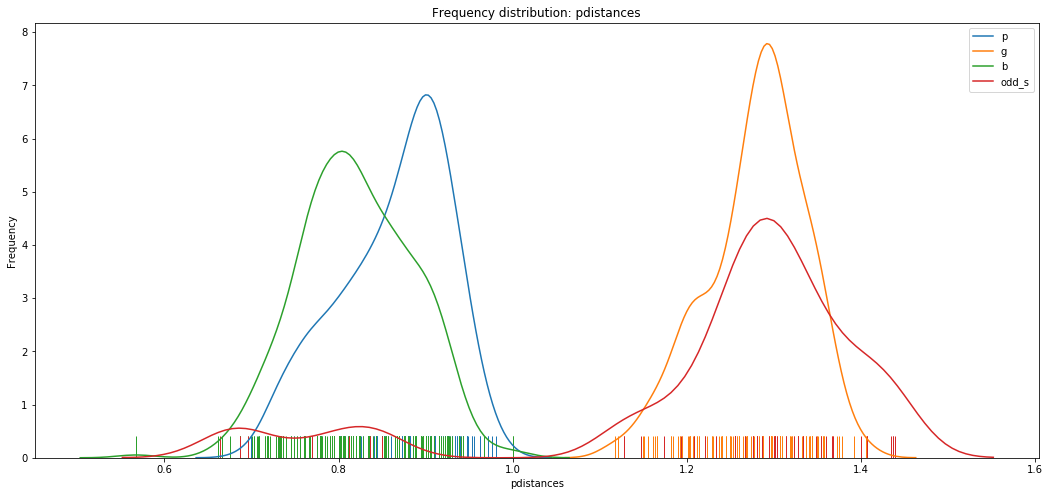

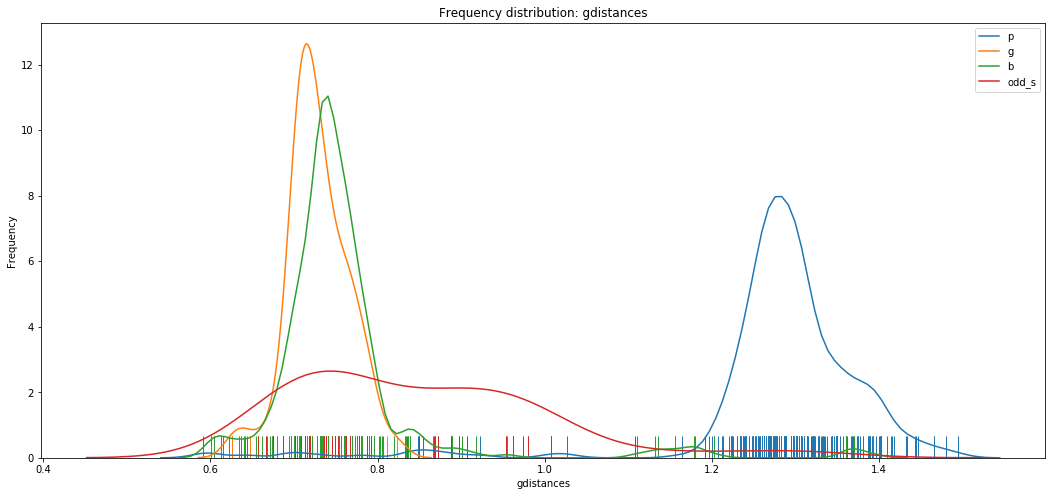

In [11]:
"""After first tests"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in filtrates_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



totallengths averages: 
p : 65 
g : 60 
b : 47 
odd_s : 80 
broken : 48 
totallengths variances: 
p : 7 
g : 3 
b : 5 
odd_s : 774 
broken : 1110 
num_opconnections averages: 
p : 1 
g : 1 
b : 2 
odd_s : 1 
broken : 1 
num_opconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 0 
num_gconnections averages: 
p : 0 
g : 1 
b : 1 
odd_s : 1 
broken : 0 
num_gconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 0 
num_fpconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 0 
broken : 1 
num_fpconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_fgconnections averages: 
p : 1 
g : 1 
b : 1 
odd_s : 2 
broken : 0 
num_fgconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 2 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_blobs averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
broken : 3 
num_blobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
pto

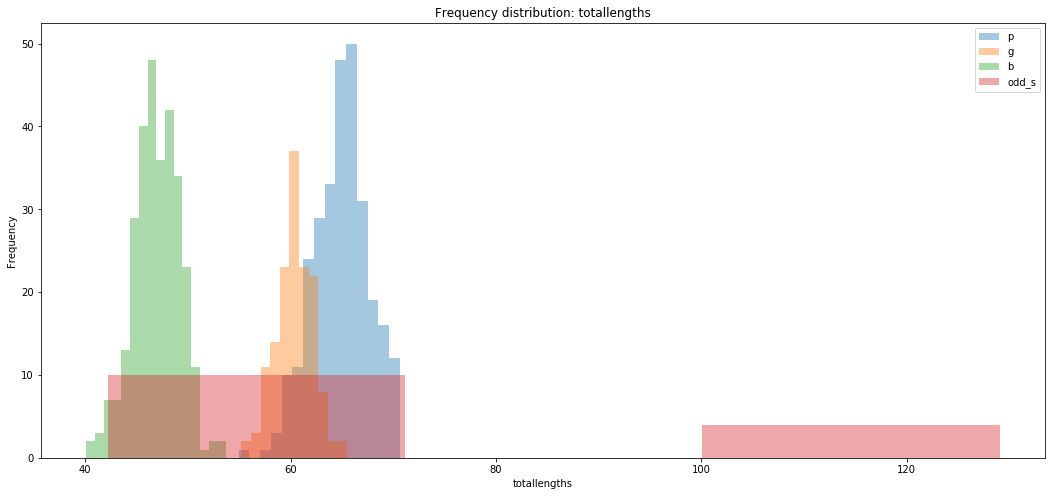

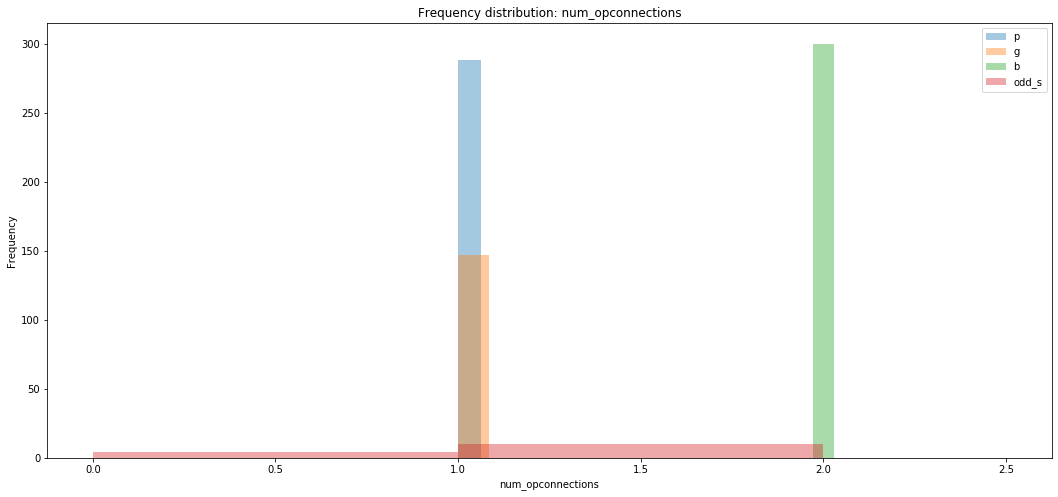

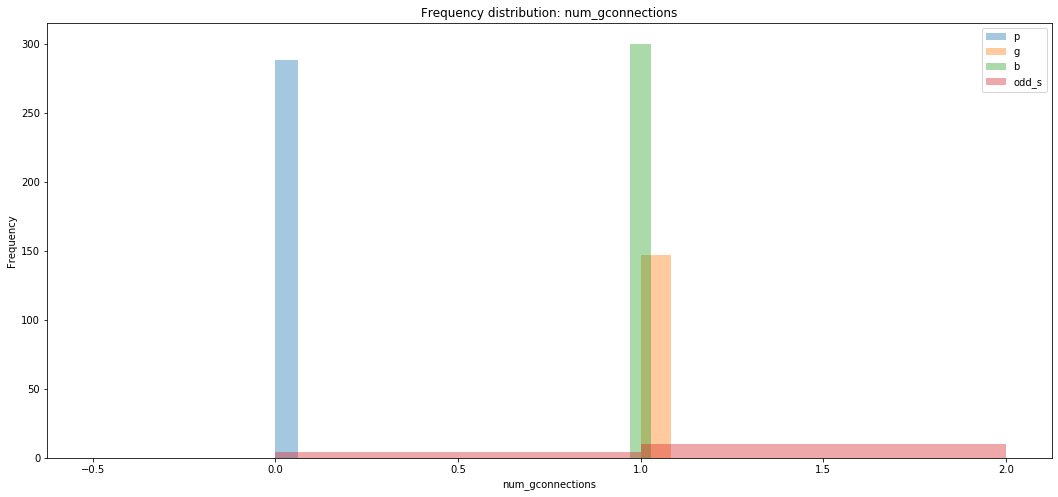

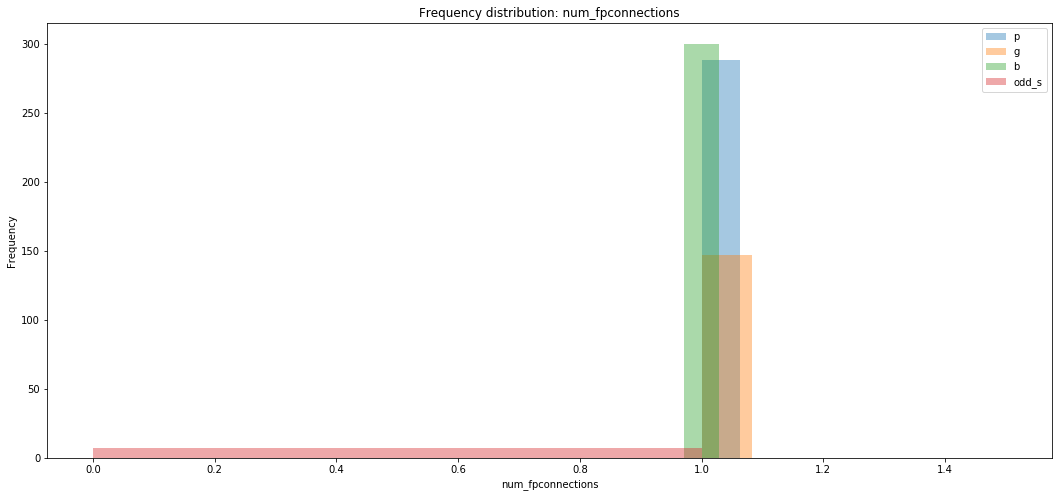

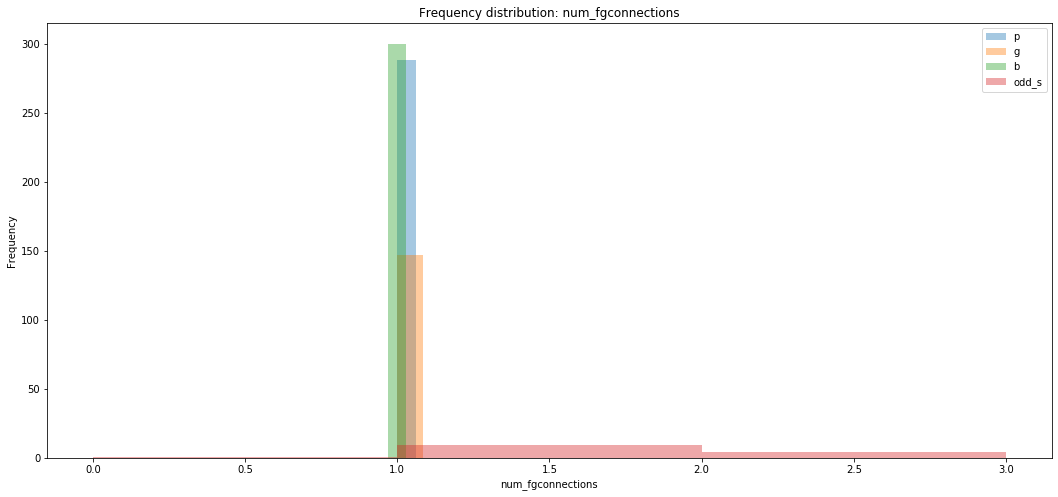

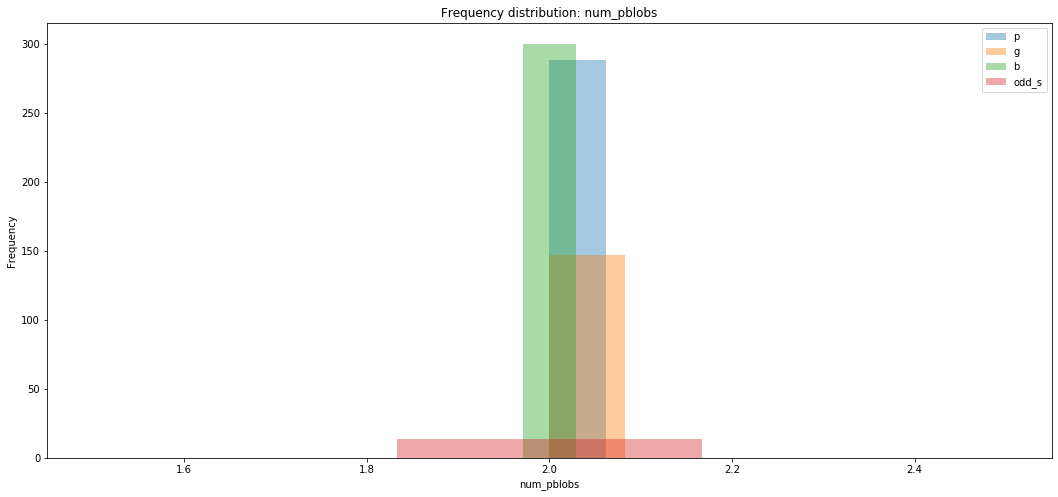

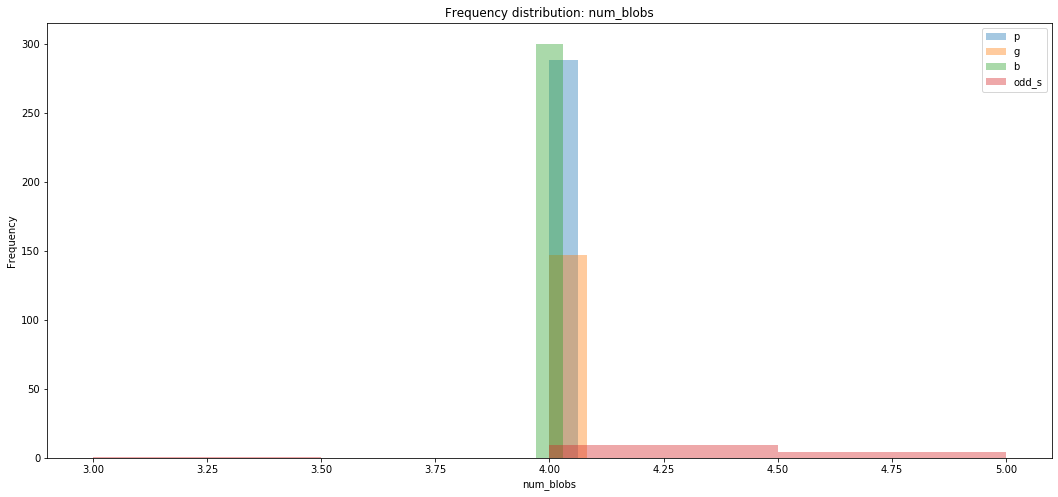

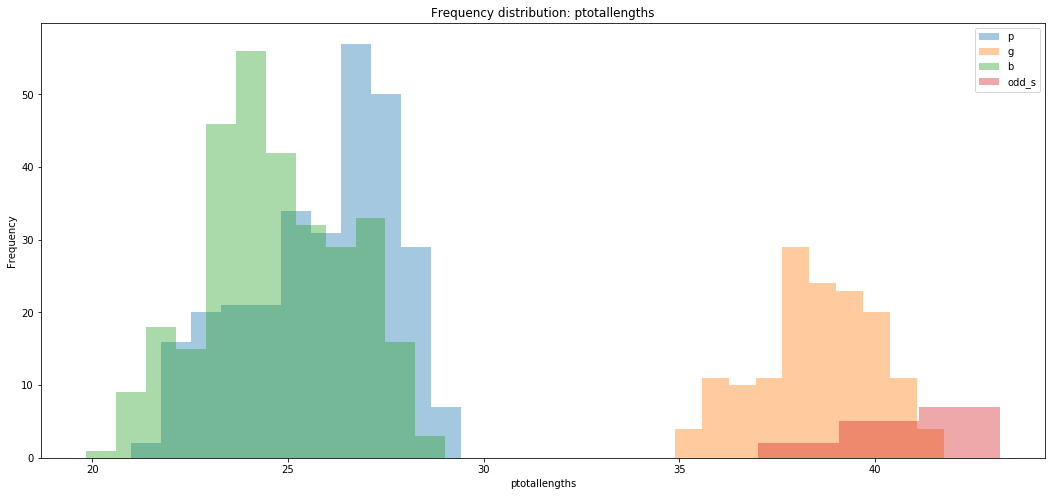

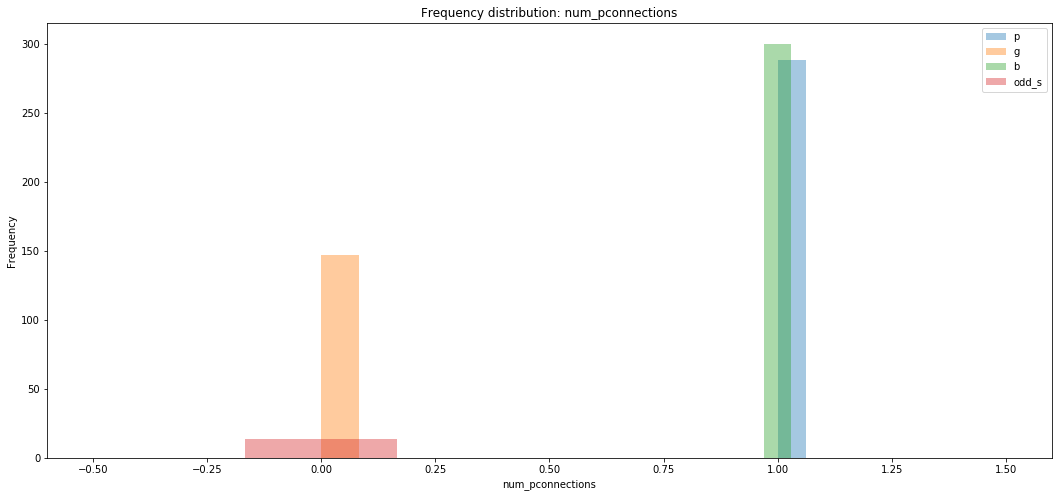

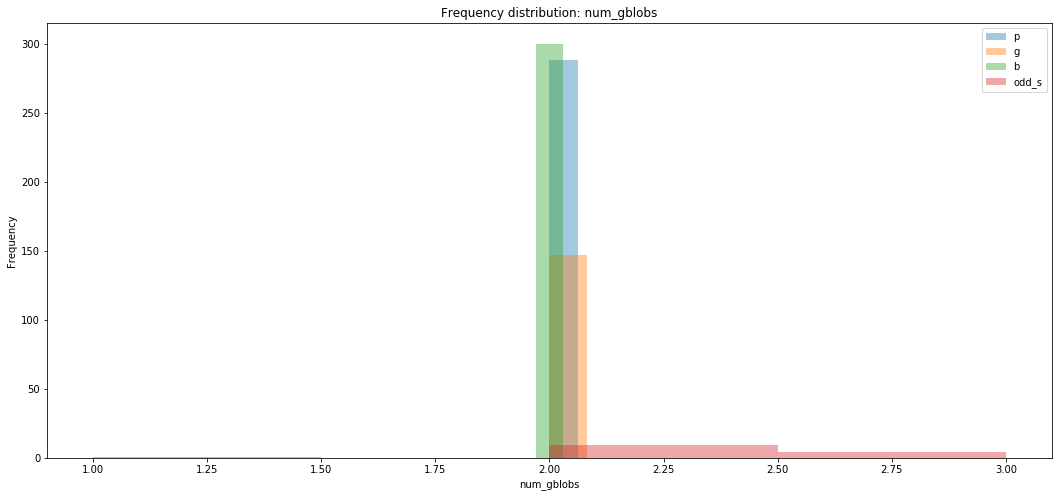

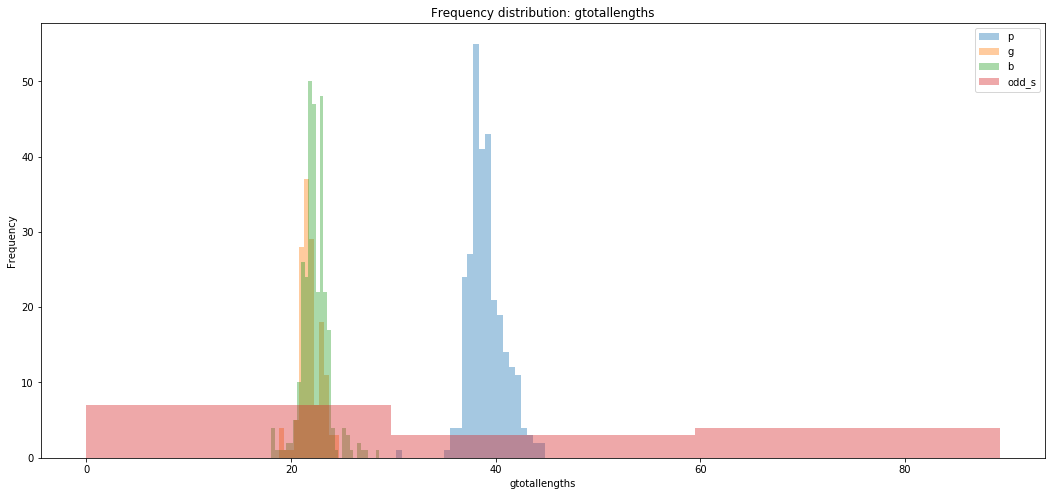

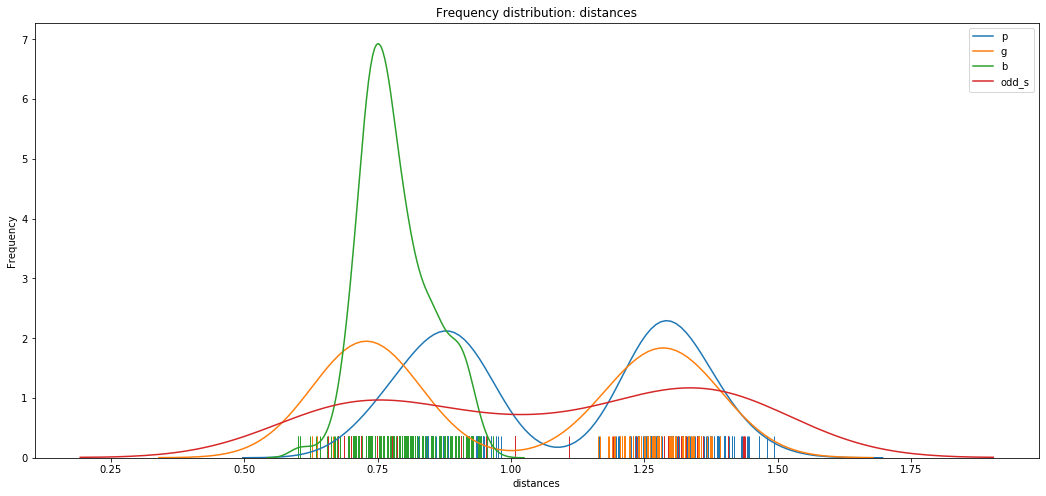

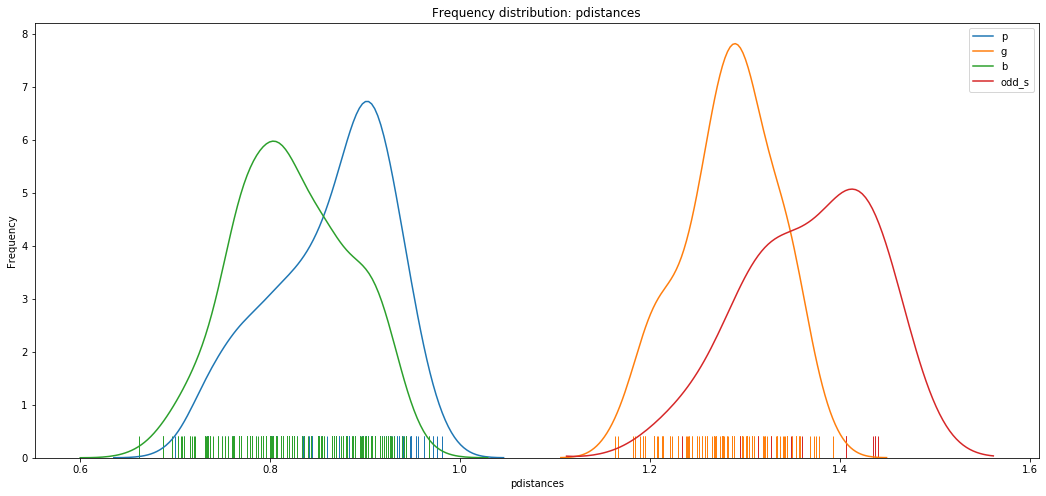

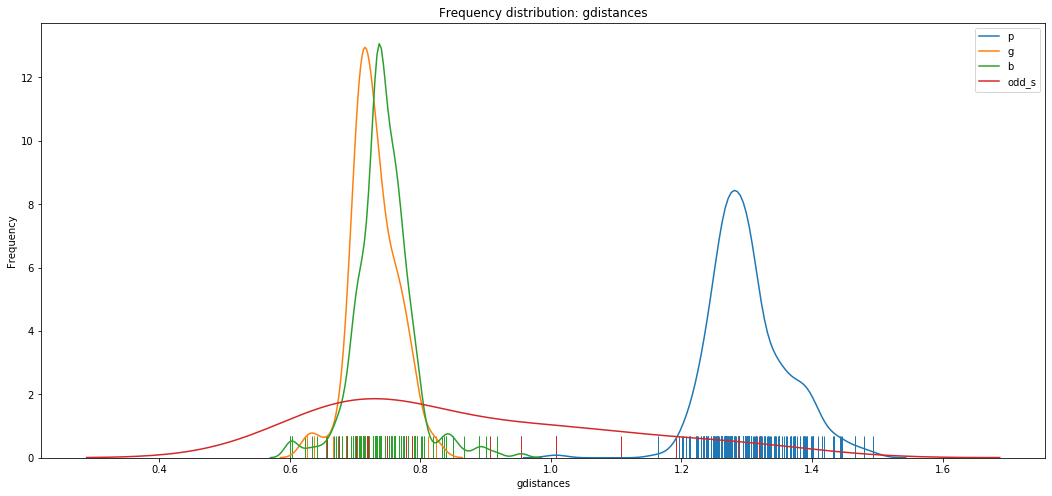

In [12]:

"""Correctly classified"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in passes[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
